# Overview

This Colab helps to create and validate a training set for the k-NN classifier described in the MediaPipe [Pose Classification](https://google.github.io/mediapipe/solutions/pose_classification.html) soultion, test it on an arbitrary video, export to a CSV and then use it in the [ML Kit sample app](https://developers.google.com/ml-kit/vision/pose-detection/classifying-poses#4_integrate_with_the_ml_kit_quickstart_app).

# Codebase

In [14]:
from matplotlib import pyplot as plt


def show_image(img, figsize=(10, 10)):
  """Shows output PIL image."""
  plt.figure(figsize=figsize)
  plt.imshow(img)
  plt.show()

## Commons

## Pose embedding

In [15]:
class FullBodyPoseEmbedder(object):
  """Converts 3D pose landmarks into 3D embedding."""

  def __init__(self, torso_size_multiplier=2.5):
    # Multiplier to apply to the torso to get minimal body size.
    self._torso_size_multiplier = torso_size_multiplier

    # Names of the landmarks as they appear in the prediction.
    self._landmark_names = [
        'nose',
        'left_eye_inner', 'left_eye', 'left_eye_outer',
        'right_eye_inner', 'right_eye', 'right_eye_outer',
        'left_ear', 'right_ear',
        'mouth_left', 'mouth_right',
        'left_shoulder', 'right_shoulder',
        'left_elbow', 'right_elbow',
        'left_wrist', 'right_wrist',
        'left_pinky_1', 'right_pinky_1',
        'left_index_1', 'right_index_1',
        'left_thumb_2', 'right_thumb_2',
        'left_hip', 'right_hip',
        'left_knee', 'right_knee',
        'left_ankle', 'right_ankle',
        'left_heel', 'right_heel',
        'left_foot_index', 'right_foot_index',
    ]

  def __call__(self, landmarks):
    """Normalizes pose landmarks and converts to embedding
    
    Args:
      landmarks - NumPy array with 3D landmarks of shape (N, 3).

    Result:
      Numpy array with pose embedding of shape (M, 3) where `M` is the number of
      pairwise distances defined in `_get_pose_distance_embedding`.
    """
    assert landmarks.shape[0] == len(self._landmark_names), 'Unexpected number of landmarks: {}'.format(landmarks.shape[0])

    # Get pose landmarks.
    landmarks = np.copy(landmarks)

    # Normalize landmarks.
    landmarks = self._normalize_pose_landmarks(landmarks)

    # Get embedding.
    embedding = self._get_pose_distance_embedding(landmarks)

    return embedding

  def _normalize_pose_landmarks(self, landmarks):
    """Normalizes landmarks translation and scale."""
    landmarks = np.copy(landmarks)

    # Normalize translation.
    pose_center = self._get_pose_center(landmarks)
    landmarks -= pose_center

    # Normalize scale.
    pose_size = self._get_pose_size(landmarks, self._torso_size_multiplier)
    landmarks /= pose_size
    # Multiplication by 100 is not required, but makes it easier to debug.
    landmarks *= 100

    return landmarks

  def _get_pose_center(self, landmarks):
    """Calculates pose center as point between hips."""
    left_hip = landmarks[self._landmark_names.index('left_hip')]
    right_hip = landmarks[self._landmark_names.index('right_hip')]
    center = (left_hip + right_hip) * 0.5
    return center

  def _get_pose_size(self, landmarks, torso_size_multiplier):
    """Calculates pose size.
    
    It is the maximum of two values:
      * Torso size multiplied by `torso_size_multiplier`
      * Maximum distance from pose center to any pose landmark
    """
    # This approach uses only 2D landmarks to compute pose size.
    landmarks = landmarks[:, :2]

    # Hips center.
    left_hip = landmarks[self._landmark_names.index('left_hip')]
    right_hip = landmarks[self._landmark_names.index('right_hip')]
    hips = (left_hip + right_hip) * 0.5

    # Shoulders center.
    left_shoulder = landmarks[self._landmark_names.index('left_shoulder')]
    right_shoulder = landmarks[self._landmark_names.index('right_shoulder')]
    shoulders = (left_shoulder + right_shoulder) * 0.5

    # Torso size as the minimum body size.
    torso_size = np.linalg.norm(shoulders - hips)

    # Max dist to pose center.
    pose_center = self._get_pose_center(landmarks)
    max_dist = np.max(np.linalg.norm(landmarks - pose_center, axis=1))

    return max(torso_size * torso_size_multiplier, max_dist)

  def _get_pose_distance_embedding(self, landmarks):
    """Converts pose landmarks into 3D embedding.

    We use several pairwise 3D distances to form pose embedding. All distances
    include X and Y components with sign. We differnt types of pairs to cover
    different pose classes. Feel free to remove some or add new.
    
    Args:
      landmarks - NumPy array with 3D landmarks of shape (N, 3).

    Result:
      Numpy array with pose embedding of shape (M, 3) where `M` is the number of
      pairwise distances.
    """
    embedding = np.array([
        # One joint.

        self._get_distance(
            self._get_average_by_names(landmarks, 'left_hip', 'right_hip'),
            self._get_average_by_names(landmarks, 'left_shoulder', 'right_shoulder')),

        self._get_distance_by_names(landmarks, 'left_shoulder', 'left_elbow'),
        self._get_distance_by_names(landmarks, 'right_shoulder', 'right_elbow'),

        self._get_distance_by_names(landmarks, 'left_elbow', 'left_wrist'),
        self._get_distance_by_names(landmarks, 'right_elbow', 'right_wrist'),

        self._get_distance_by_names(landmarks, 'left_hip', 'left_knee'),
        self._get_distance_by_names(landmarks, 'right_hip', 'right_knee'),

        self._get_distance_by_names(landmarks, 'left_knee', 'left_ankle'),
        self._get_distance_by_names(landmarks, 'right_knee', 'right_ankle'),

        # Two joints.

        self._get_distance_by_names(landmarks, 'left_shoulder', 'left_wrist'),
        self._get_distance_by_names(landmarks, 'right_shoulder', 'right_wrist'),

        self._get_distance_by_names(landmarks, 'left_hip', 'left_ankle'),
        self._get_distance_by_names(landmarks, 'right_hip', 'right_ankle'),

        # Four joints.

        self._get_distance_by_names(landmarks, 'left_hip', 'left_wrist'),
        self._get_distance_by_names(landmarks, 'right_hip', 'right_wrist'),

        # Five joints.

        self._get_distance_by_names(landmarks, 'left_shoulder', 'left_ankle'),
        self._get_distance_by_names(landmarks, 'right_shoulder', 'right_ankle'),
        
        self._get_distance_by_names(landmarks, 'left_hip', 'left_wrist'),
        self._get_distance_by_names(landmarks, 'right_hip', 'right_wrist'),

        # Cross body.

        self._get_distance_by_names(landmarks, 'left_elbow', 'right_elbow'),
        self._get_distance_by_names(landmarks, 'left_knee', 'right_knee'),

        self._get_distance_by_names(landmarks, 'left_wrist', 'right_wrist'),
        self._get_distance_by_names(landmarks, 'left_ankle', 'right_ankle'),

        # Body bent direction.

        # self._get_distance(
        #     self._get_average_by_names(landmarks, 'left_wrist', 'left_ankle'),
        #     landmarks[self._landmark_names.index('left_hip')]),
        # self._get_distance(
        #     self._get_average_by_names(landmarks, 'right_wrist', 'right_ankle'),
        #     landmarks[self._landmark_names.index('right_hip')]),
    ])

    return embedding

  def _get_average_by_names(self, landmarks, name_from, name_to):
    lmk_from = landmarks[self._landmark_names.index(name_from)]
    lmk_to = landmarks[self._landmark_names.index(name_to)]
    return (lmk_from + lmk_to) * 0.5

  def _get_distance_by_names(self, landmarks, name_from, name_to):
    lmk_from = landmarks[self._landmark_names.index(name_from)]
    lmk_to = landmarks[self._landmark_names.index(name_to)]
    return self._get_distance(lmk_from, lmk_to)

  def _get_distance(self, lmk_from, lmk_to):
    return lmk_to - lmk_from

## Pose classification

In [16]:
class PoseSample(object):

  def __init__(self, name, landmarks, class_name, embedding):
    self.name = name
    self.landmarks = landmarks
    self.class_name = class_name
    
    self.embedding = embedding


class PoseSampleOutlier(object):

  def __init__(self, sample, detected_class, all_classes):
    self.sample = sample
    self.detected_class = detected_class
    self.all_classes = all_classes

In [17]:
import csv
import numpy as np
import os

class PoseClassifier(object):
  """Classifies pose landmarks."""

  def __init__(self,
               pose_samples_folder,
               pose_embedder,
               file_extension='csv',
               file_separator=',',
               n_landmarks=33,
               n_dimensions=3,
               top_n_by_max_distance=30,
               top_n_by_mean_distance=10,
               axes_weights=(1., 1., 0.2)):
    self._pose_embedder = pose_embedder
    self._n_landmarks = n_landmarks
    self._n_dimensions = n_dimensions
    self._top_n_by_max_distance = top_n_by_max_distance
    self._top_n_by_mean_distance = top_n_by_mean_distance
    self._axes_weights = axes_weights

    self._pose_samples = self._load_pose_samples(pose_samples_folder,
                                                 file_extension,
                                                 file_separator,
                                                 n_landmarks,
                                                 n_dimensions,
                                                 pose_embedder)

  def _load_pose_samples(self,
                         pose_samples_folder,
                         file_extension,
                         file_separator,
                         n_landmarks,
                         n_dimensions,
                         pose_embedder):
    """Loads pose samples from a given folder.
    
    Required folder structure:
      neutral_standing.csv
      pushups_down.csv
      pushups_up.csv
      squats_down.csv
      ...

    Required CSV structure:
      sample_00001,x1,y1,z1,x2,y2,z2,....
      sample_00002,x1,y1,z1,x2,y2,z2,....
      ...
    """
    # Each file in the folder represents one pose class.
    file_names = [name for name in os.listdir(pose_samples_folder) if name.endswith(file_extension)]

    pose_samples = []
    for file_name in file_names:
      # Use file name as pose class name.
      class_name = file_name[:-(len(file_extension) + 1)]
      
      # Parse CSV.
      with open(os.path.join(pose_samples_folder, file_name)) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=file_separator)
        csv_reader = (row for row in csv_reader if row) # Filter out empty rows
        for row in csv_reader:
          assert len(row) == n_landmarks * n_dimensions + 1, 'Wrong number of values: {}'.format(len(row))
          landmarks = np.array(row[1:], np.float32).reshape([n_landmarks, n_dimensions])
          pose_samples.append(PoseSample(
              name=row[0],
              landmarks=landmarks,
              class_name=class_name,
              embedding=pose_embedder(landmarks),
          ))

    return pose_samples

  def find_pose_sample_outliers(self):
    """Classifies each sample against the entire database."""
    # Find outliers in target poses
    outliers = []
    for sample in self._pose_samples:
      # Find nearest poses for the target one.
      pose_landmarks = sample.landmarks.copy()
      pose_classification = self.__call__(pose_landmarks)
      class_names = [class_name for class_name, count in pose_classification.items() if count == max(pose_classification.values())]

      # Sample is an outlier if nearest poses have different class or more than
      # one pose class is detected as nearest.
      if sample.class_name not in class_names or len(class_names) != 1:
        outliers.append(PoseSampleOutlier(sample, class_names, pose_classification))

    return outliers

  def __call__(self, pose_landmarks):
    """Classifies given pose.

    Classification is done in two stages:
      * First we pick top-N samples by MAX distance. It allows to remove samples
        that are almost the same as given pose, but has few joints bent in the
        other direction.
      * Then we pick top-N samples by MEAN distance. After outliers are removed
        on a previous step, we can pick samples that are closes on average.
    
    Args:
      pose_landmarks: NumPy array with 3D landmarks of shape (N, 3).

    Returns:
      Dictionary with count of nearest pose samples from the database. Sample:
        {
          'pushups_down': 8,
          'pushups_up': 2,
        }
    """
    # Check that provided and target poses have the same shape.
    assert pose_landmarks.shape == (self._n_landmarks, self._n_dimensions), 'Unexpected shape: {}'.format(pose_landmarks.shape)

    # Get given pose embedding.
    pose_embedding = self._pose_embedder(pose_landmarks)
    flipped_pose_embedding = self._pose_embedder(pose_landmarks * np.array([-1, 1, 1]))

    # Filter by max distance.
    #
    # That helps to remove outliers - poses that are almost the same as the
    # given one, but has one joint bent into another direction and actually
    # represnt a different pose class.
    max_dist_heap = []
    for sample_idx, sample in enumerate(self._pose_samples):
      max_dist = min(
          np.max(np.abs(sample.embedding - pose_embedding) * self._axes_weights),
          np.max(np.abs(sample.embedding - flipped_pose_embedding) * self._axes_weights),
      )
      max_dist_heap.append([max_dist, sample_idx])

    max_dist_heap = sorted(max_dist_heap, key=lambda x: x[0])
    max_dist_heap = max_dist_heap[:self._top_n_by_max_distance]

    # Filter by mean distance.
    #
    # After removing outliers we can find the nearest pose by mean distance.
    mean_dist_heap = []
    for _, sample_idx in max_dist_heap:
      sample = self._pose_samples[sample_idx]
      mean_dist = min(
          np.mean(np.abs(sample.embedding - pose_embedding) * self._axes_weights),
          np.mean(np.abs(sample.embedding - flipped_pose_embedding) * self._axes_weights),
      )
      mean_dist_heap.append([mean_dist, sample_idx])

    mean_dist_heap = sorted(mean_dist_heap, key=lambda x: x[0])
    mean_dist_heap = mean_dist_heap[:self._top_n_by_mean_distance]

    # Collect results into map: (class_name -> n_samples)
    class_names = [self._pose_samples[sample_idx].class_name for _, sample_idx in mean_dist_heap]
    result = {class_name: class_names.count(class_name) for class_name in set(class_names)}

    return result

## Classification smoothing

In [18]:
class EMADictSmoothing(object):
  """Smoothes pose classification."""

  def __init__(self, window_size=10, alpha=0.2):
    self._window_size = window_size
    self._alpha = alpha

    self._data_in_window = []

  def __call__(self, data):
    """Smoothes given pose classification.

    Smoothing is done by computing Exponential Moving Average for every pose
    class observed in the given time window. Missed pose classes are replaced
    with 0.
    
    Args:
      data: Dictionary with pose classification. Sample:
          {
            'pushups_down': 8,
            'pushups_up': 2,
          }

    Result:
      Dictionary in the same format but with smoothed and float instead of
      integer values. Sample:
        {
          'pushups_down': 8.3,
          'pushups_up': 1.7,
        }
    """
    # Add new data to the beginning of the window for simpler code.
    self._data_in_window.insert(0, data)
    self._data_in_window = self._data_in_window[:self._window_size]

    # Get all keys.
    keys = set([key for data in self._data_in_window for key, _ in data.items()])

    # Get smoothed values.
    smoothed_data = dict()
    for key in keys:
      factor = 1.0
      top_sum = 0.0
      bottom_sum = 0.0
      for data in self._data_in_window:
        value = data[key] if key in data else 0.0

        top_sum += factor * value
        bottom_sum += factor

        # Update factor.
        factor *= (1.0 - self._alpha)

      smoothed_data[key] = top_sum / bottom_sum

    return smoothed_data

## Repetition counter

In [19]:
class RepetitionCounter(object):
  """Counts number of repetitions of given target pose class."""

  def __init__(self, class_name, enter_threshold=6, exit_threshold=4):
    self._class_name = class_name

    # If pose counter passes given threshold, then we enter the pose.
    self._enter_threshold = enter_threshold
    self._exit_threshold = exit_threshold

    # Either we are in given pose or not.
    self._pose_entered = False

    # Number of times we exited the pose.
    self._n_repeats = 0

  @property
  def n_repeats(self):
    return self._n_repeats

  def __call__(self, pose_classification):
    """Counts number of repetitions happend until given frame.

    We use two thresholds. First you need to go above the higher one to enter
    the pose, and then you need to go below the lower one to exit it. Difference
    between the thresholds makes it stable to prediction jittering (which will
    cause wrong counts in case of having only one threshold).
    
    Args:
      pose_classification: Pose classification dictionary on current frame.
        Sample:
          {
            'pushups_down': 8.3,
            'pushups_up': 1.7,
          }

    Returns:
      Integer counter of repetitions.
    """
    # Get pose confidence.
    pose_confidence = 0.0
    if self._class_name in pose_classification:
      pose_confidence = pose_classification[self._class_name]

    # On the very first frame or if we were out of the pose, just check if we
    # entered it on this frame and update the state.
    if not self._pose_entered:
      self._pose_entered = pose_confidence > self._enter_threshold
      return self._n_repeats

    # If we were in the pose and are exiting it, then increase the counter and
    # update the state.
    if pose_confidence < self._exit_threshold:
      self._n_repeats += 1
      self._pose_entered = False

    return self._n_repeats

In [21]:
class PoseChecker(object):
    """Counts number of repetitions of given target pose class."""

    def __init__(self,enter_threshold=6, exit_threshold=4):
        self._enter_threshold = enter_threshold
        self._exit_threshold = exit_threshold

        self._pose_entered = False
        self._pose_exited = False


    def __call__(self, class_name, pose_classification):

        pose_confidence = 0.0

        if class_name in pose_classification:
            pose_confidence = pose_classification[class_name]
        
        # calc entered state
        if not self._pose_entered:
            self._pose_entered = pose_confidence > self._enter_threshold

        if self._pose_entered:
            self._pose_exited = False

        if pose_confidence < self._exit_threshold:
            self._pose_entered = False
            self._pose_exited = True

        return self._pose_entered, self._pose_exited


## Classification visualizer

In [28]:
import io
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import requests

class PoseClassificationVisualizer(object):
  """Keeps track of claassifcations for every frame and renders them."""

  def __init__(self,
               plot_location_x=0.05,
               plot_location_y=0.05,
               plot_max_width=0.4,
               plot_max_height=0.4,
               plot_figsize=(9, 4),
               plot_x_max=None,
               plot_y_max=None,
               counter_location_x=0.5,
               counter_location_y=0.05,
               counter_font_path='https://github.com/googlefonts/roboto/blob/main/src/hinted/Roboto-Regular.ttf?raw=true',
               counter_font_color='red',
               counter_font_size=0.02):
    self._plot_location_x = plot_location_x
    self._plot_location_y = plot_location_y
    self._plot_max_width = plot_max_width
    self._plot_max_height = plot_max_height
    self._plot_figsize = plot_figsize
    self._plot_x_max = plot_x_max
    self._plot_y_max = plot_y_max
    self._counter_location_x = counter_location_x
    self._counter_location_y = counter_location_y
    self._counter_font_path = counter_font_path
    self._counter_font_color = counter_font_color
    self._counter_font_size = counter_font_size

    self._counter_font = None

    self._pose_classification_history = []
    self._pose_classification_filtered_history = []

  def __call__(self,
               class_name,
               frame,
               pose_classification,
               pose_classification_filtered
               ):
    """Renders pose classifcation and counter until given frame."""
    # Extend classification history.
    self._pose_classification_history.append(pose_classification)
    self._pose_classification_filtered_history.append(pose_classification_filtered)

    # Output frame with classification plot and counter.
    output_img = Image.fromarray(frame)

    output_width = output_img.size[0]
    output_height = output_img.size[1]

    # Draw the plot.
    img = self._plot_classification_history(class_name, output_width, output_height)
    img.thumbnail((int(output_width * self._plot_max_width),
                   int(output_height * self._plot_max_height)),
                  Image.ANTIALIAS)
    output_img.paste(img,
                     (int(output_width * self._plot_location_x),
                      int(output_height * self._plot_location_y)))

    class_names = [class_name for class_name, count in pose_classification.items() if count == max(pose_classification.values())]

    # Draw the count.
    output_img_draw = ImageDraw.Draw(output_img)
    if self._counter_font is None:
      font_size = int(output_height * self._counter_font_size)
      font_request = requests.get(self._counter_font_path, allow_redirects=True)
      self._counter_font = ImageFont.truetype(io.BytesIO(font_request.content), size=font_size)
    str1 = 'ref: ' + str(class_name)
    output_img_draw.text((output_width * self._counter_location_x,
                          output_height * (self._counter_location_y + 0.05)),
                         str1,
                         font=self._counter_font,
                         fill=self._counter_font_color)
    str2 = 'crnt: ' + str(class_names[0])
    output_img_draw.text((output_width * self._counter_location_x,
                          output_height * self._counter_location_y),
                         str2,
                         font=self._counter_font,
                         fill=self._counter_font_color)

    return output_img

  def _plot_classification_history(self, class_name, output_width, output_height):
    fig = plt.figure(figsize=self._plot_figsize)

    for classification_history in [self._pose_classification_history,
                                   self._pose_classification_filtered_history]:
      y = []
      for classification in classification_history:
        if classification is None:
          y.append(None)
        elif class_name in classification:
          y.append(classification[class_name])
        else:
          y.append(0)
      plt.plot(y, linewidth=7)

    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Frame')
    plt.ylabel('Confidence')
    plt.title('Classification history for `{}`'.format(class_name))
    plt.legend(loc='upper right')

    if self._plot_y_max is not None:
      plt.ylim(top=self._plot_y_max)
    if self._plot_x_max is not None:
      plt.xlim(right=self._plot_x_max)

    # Convert plot to image.
    buf = io.BytesIO()
    dpi = min(
        output_width * self._plot_max_width / float(self._plot_figsize[0]),
        output_height * self._plot_max_height / float(self._plot_figsize[1]))
    fig.savefig(buf, dpi=dpi)
    buf.seek(0)
    img = Image.open(buf)
    plt.close()

    return img

## Bootstrap helper

In [34]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
from PIL import Image
import sys
import tqdm

from mediapipe.python.solutions import drawing_utils as mp_drawing
from mediapipe.python.solutions import pose as mp_pose


class BootstrapHelper(object):
    """Helps to bootstrap images and filter pose samples for classification."""

    def __init__(self,
                 images_in_folder,
                 images_out_folder,
                 csvs_out_folder):
        self._images_in_folder = images_in_folder
        self._images_out_folder = images_out_folder
        self._csvs_out_folder = csvs_out_folder

        # Get list of pose classes and print image statistics.
        self._pose_class_names = sorted([n for n in os.listdir(
            self._images_in_folder) if not n.startswith('.')])

    def bootstrap(self, per_pose_class_limit=None):
        """Bootstraps images in a given folder.

        Required image in folder (same use for image out folder):
          pushups_up/
            image_001.jpg
            image_002.jpg
            ...
          pushups_down/
            image_001.jpg
            image_002.jpg
            ...
          ...

        Produced CSVs out folder:
          pushups_up.csv
          pushups_down.csv

        Produced CSV structure with pose 3D landmarks:
          sample_00001,x1,y1,z1,x2,y2,z2,....
          sample_00002,x1,y1,z1,x2,y2,z2,....
        """
        # Create output folder for CVSs.
        if not os.path.exists(self._csvs_out_folder):
            os.makedirs(self._csvs_out_folder)

        for pose_class_name in self._pose_class_names:
            print('Bootstrapping ', pose_class_name, file=sys.stderr)

            # Paths for the pose class.
            images_in_folder = os.path.join(
                self._images_in_folder, pose_class_name)
            images_out_folder = os.path.join(
                self._images_out_folder, pose_class_name)
            csv_out_path = os.path.join(
                self._csvs_out_folder, pose_class_name + '.csv')
            if not os.path.exists(images_out_folder):
                os.makedirs(images_out_folder)

            with open(csv_out_path, 'w') as csv_out_file:
                csv_out_writer = csv.writer(
                    csv_out_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
                # Get list of images.
                image_names = sorted([n for n in os.listdir(
                    images_in_folder) if not n.startswith('.')])
                if per_pose_class_limit is not None:
                    image_names = image_names[:per_pose_class_limit]

                # Bootstrap every image.
                for image_name in tqdm.tqdm(image_names):
                    # Load image.
                    input_frame = cv2.imread(
                        os.path.join(images_in_folder, image_name))
                    input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)

                    # Initialize fresh pose tracker and run it.
                    with mp_pose.Pose(model_complexity=2,
                                      min_detection_confidence=0.5,
                                      min_tracking_confidence=0.5) as pose_tracker:
                        result = pose_tracker.process(image=input_frame)
                        pose_landmarks = result.pose_landmarks

                    # Save image with pose prediction (if pose was detected).
                    output_frame = input_frame.copy()
                    if pose_landmarks is not None:
                        mp_drawing.draw_landmarks(
                            image=output_frame,
                            landmark_list=pose_landmarks,
                            connections=mp_pose.POSE_CONNECTIONS)
                    output_frame = cv2.cvtColor(
                        output_frame, cv2.COLOR_RGB2BGR)
                    cv2.imwrite(os.path.join(
                        images_out_folder, image_name), output_frame)

                    # Save landmarks if pose was detected.
                    if pose_landmarks is not None:
                        # Get landmarks.
                        frame_height, frame_width = output_frame.shape[0], output_frame.shape[1]
                        pose_landmarks = np.array(
                            [[lmk.x * frame_width, lmk.y * frame_height, lmk.z * frame_width]
                             for lmk in pose_landmarks.landmark],
                            dtype=np.float32)
                        assert pose_landmarks.shape == (
                            33, 3), 'Unexpected landmarks shape: {}'.format(pose_landmarks.shape)
                        csv_out_writer.writerow(
                            [image_name] + pose_landmarks.flatten().astype(np.str).tolist())

                    # Draw XZ projection and concatenate with the image.
                    projection_xz = self._draw_xz_projection(
                        output_frame=output_frame, pose_landmarks=pose_landmarks)
                    output_frame = np.concatenate(
                        (output_frame, projection_xz), axis=1)

    def _draw_xz_projection(self, output_frame, pose_landmarks, r=0.5, color='red'):
        frame_height, frame_width = output_frame.shape[0], output_frame.shape[1]
        img = Image.new('RGB', (frame_width, frame_height), color='white')

        if pose_landmarks is None:
            return np.asarray(img)

        # Scale radius according to the image width.
        r *= frame_width * 0.01

        draw = ImageDraw.Draw(img)
        for idx_1, idx_2 in mp_pose.POSE_CONNECTIONS:
            # Flip Z and move hips center to the center of the image.
            x1, y1, z1 = pose_landmarks[idx_1] * \
                [1, 1, -1] + [0, 0, frame_height * 0.5]
            x2, y2, z2 = pose_landmarks[idx_2] * \
                [1, 1, -1] + [0, 0, frame_height * 0.5]

            draw.ellipse([x1 - r, z1 - r, x1 + r, z1 + r], fill=color)
            draw.ellipse([x2 - r, z2 - r, x2 + r, z2 + r], fill=color)
            draw.line([x1, z1, x2, z2], width=int(r), fill=color)

        return np.asarray(img)

    def align_images_and_csvs(self, print_removed_items=False):
        """Makes sure that image folders and CSVs have the same sample.

        Leaves only intersetion of samples in both image folders and CSVs.
        """
        for pose_class_name in self._pose_class_names:
            # Paths for the pose class.
            images_out_folder = os.path.join(
                self._images_out_folder, pose_class_name)
            csv_out_path = os.path.join(
                self._csvs_out_folder, pose_class_name + '.csv')

            # Read CSV into memory.
            rows = []
            with open(csv_out_path) as csv_out_file:
                csv_out_reader = csv.reader(csv_out_file, delimiter=',')
                # Filter out empty rows
                csv_out_reader = (row for row in csv_out_reader if row)
                for row in csv_out_reader:
                    rows.append(row)

            # Image names left in CSV.
            image_names_in_csv = []

            # Re-write the CSV removing lines without corresponding images.
            with open(csv_out_path, 'w') as csv_out_file:
                csv_out_writer = csv.writer(
                    csv_out_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
                for row in rows:
                    image_name = row[0]
                    image_path = os.path.join(images_out_folder, image_name)
                    if os.path.exists(image_path):
                        image_names_in_csv.append(image_name)
                        csv_out_writer.writerow(row)
                    elif print_removed_items:
                        print('Removed image from CSV: ', image_path)

            # Remove images without corresponding line in CSV.
            for image_name in os.listdir(images_out_folder):
                if image_name not in image_names_in_csv:
                    image_path = os.path.join(images_out_folder, image_name)
                    os.remove(image_path)
                    if print_removed_items:
                        print('Removed image from folder: ', image_path)

    def analyze_outliers(self, outliers):
        """Classifies each sample agains all other to find outliers.

        If sample is classified differrrently than the original class - it sould
        either be deleted or more similar samples should be aadded.
        """
        for outlier in outliers:
            image_path = os.path.join(
                self._images_out_folder, outlier.sample.class_name, outlier.sample.name)

            print('Outlier')
            print('  sample path =    ', image_path)
            print('  sample class =   ', outlier.sample.class_name)
            print('  detected class = ', outlier.detected_class)
            print('  all classes =    ', outlier.all_classes)

            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            show_image(img, figsize=(20, 20))

    def remove_outliers(self, outliers):
        """Removes outliers from the image folders."""
        for outlier in outliers:
            image_path = os.path.join(
                self._images_out_folder, outlier.sample.class_name, outlier.sample.name)
            os.remove(image_path)

    def print_images_in_statistics(self):
        """Prints statistics from the input image folder."""
        self._print_images_statistics(
            self._images_in_folder, self._pose_class_names)

    def print_images_out_statistics(self):
        """Prints statistics from the output image folder."""
        self._print_images_statistics(
            self._images_out_folder, self._pose_class_names)

    def _print_images_statistics(self, images_folder, pose_class_names):
        print('Number of images per pose class:')
        for pose_class_name in pose_class_names:
            n_images = len([
                n for n in os.listdir(os.path.join(images_folder, pose_class_name))
                if not n.startswith('.')])
            print('  {}: {}'.format(pose_class_name, n_images))


# Step 1: Build classifier

## Bootstrap images

In [35]:
# Required structure of the images_in_folder:
#
#   fitness_poses_images_in/
#     pushups_up/
#       image_001.jpg
#       image_002.jpg
#       ...
#     pushups_down/
#       image_001.jpg
#       image_002.jpg
#       ...
#     ...
bootstrap_images_in_folder = r'D:\videos\yoga\yoga_images_in'

# Output folders for bootstrapped images and CSVs.
bootstrap_images_out_folder = r'D:\videos\yoga\yoga_images_out'
bootstrap_csvs_out_folder = r'D:\videos\yoga\yoga_csvs_out'

In [36]:
# Initialize helper.
bootstrap_helper = BootstrapHelper(
    images_in_folder=bootstrap_images_in_folder,
    images_out_folder=bootstrap_images_out_folder,
    csvs_out_folder=bootstrap_csvs_out_folder,
)

In [37]:
# Check how many pose classes and images for them are available.
bootstrap_helper.print_images_in_statistics()

Number of images per pose class:
  yoga_raise: 147
  yoga_ready: 128
  yoga_stretch_arm: 141


In [38]:
# Bootstrap all images.
# Set limit to some small number for debug.
bootstrap_helper.bootstrap(per_pose_class_limit=None)

Bootstrapping  yoga_raise
  0%|          | 0/147 [00:00<?, ?it/s]C:\Users\jyz18\AppData\Local\Temp/ipykernel_29064/2534879533.py:113: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  [image_name] + pose_landmarks.flatten().astype(np.str).tolist())
100%|██████████| 147/147 [01:15<00:00,  1.93it/s]
Bootstrapping  yoga_ready
100%|██████████| 128/128 [01:04<00:00,  1.98it/s]
Bootstrapping  yoga_stretch_arm
100%|██████████| 141/141 [01:10<00:00,  1.99it/s]


In [39]:
# Check how many images were bootstrapped.
bootstrap_helper.print_images_out_statistics()

Number of images per pose class:
  yoga_raise: 147
  yoga_ready: 128
  yoga_stretch_arm: 141


In [40]:
# After initial bootstrapping images without detected poses were still saved in
# the folderd (but not in the CSVs) for debug purpose. Let's remove them.
bootstrap_helper.align_images_and_csvs(print_removed_items=True)
bootstrap_helper.print_images_out_statistics()

Removed image from folder:  D:\videos\yoga\yoga_images_out\yoga_raise\yoga772_cam001_50.jpg
Removed image from folder:  D:\videos\yoga\yoga_images_out\yoga_raise\yoga772_cam012_50.jpg
Removed image from folder:  D:\videos\yoga\yoga_images_out\yoga_raise\yoga772_cam013_50.jpg
Removed image from folder:  D:\videos\yoga\yoga_images_out\yoga_raise\yoga772_cam017_50.jpg
Removed image from folder:  D:\videos\yoga\yoga_images_out\yoga_raise\yoga772_cam018_50.jpg
Removed image from folder:  D:\videos\yoga\yoga_images_out\yoga_raise\yoga772_cam020_50.jpg
Removed image from folder:  D:\videos\yoga\yoga_images_out\yoga_raise\yoga772_cam021_50.jpg
Removed image from folder:  D:\videos\yoga\yoga_images_out\yoga_raise\yoga772_cam024_50.jpg
Removed image from folder:  D:\videos\yoga\yoga_images_out\yoga_raise\yoga772_cam025_50.jpg
Removed image from folder:  D:\videos\yoga\yoga_images_out\yoga_raise\yoga772_cam026_50.jpg
Removed image from folder:  D:\videos\yoga\yoga_images_out\yoga_raise\yoga772_ca

## Manual filtration

Please manually verify predictions and remove samples (images) that has wrong pose prediction. Check as if you were asked to classify pose just from predicted landmarks. If you can't - remove it.

Align CSVs and image folders once you are done.

In [41]:
# Align CSVs with filtered images.
bootstrap_helper.align_images_and_csvs(print_removed_items=False)
bootstrap_helper.print_images_out_statistics()

Number of images per pose class:
  yoga_raise: 134
  yoga_ready: 111
  yoga_stretch_arm: 133


## Automatic filtration

Classify each sample against database of all other samples and check if it gets in the same class as annotated after classification.

There can be two reasons for the outliers:

  * **Wrong pose prediction**: In this case remove such outliers.

  * **Wrong classification** (i.e. pose is predicted correctly and you aggree with original pose class assigned to the sample): In this case sample is from the underrepresented group (e.g. unusual angle or just very few samples). Add more similar samples and run bootstrapping from the very beginning.

Even if you just removed some samples it makes sence to re-run automatic filtration one more time as database of poses has changed.

**Important!!** Check that you are using the same parameters when classifying whole videos later.

In [42]:
# Find outliers.

# Transforms pose landmarks into embedding.
pose_embedder = FullBodyPoseEmbedder()

# Classifies give pose against database of poses.
pose_classifier = PoseClassifier(
    pose_samples_folder=bootstrap_csvs_out_folder,
    pose_embedder=pose_embedder,
    top_n_by_max_distance=30,
    top_n_by_mean_distance=10)

outliers = pose_classifier.find_pose_sample_outliers()
print('Number of outliers: ', len(outliers))

Number of outliers:  7


Outlier
  sample path =     D:\videos\yoga\yoga_images_out\yoga_raise\yoga772_cam006_50.jpg
  sample class =    yoga_raise
  detected class =  ['yoga_ready']
  all classes =     {'yoga_raise': 1, 'yoga_ready': 9}


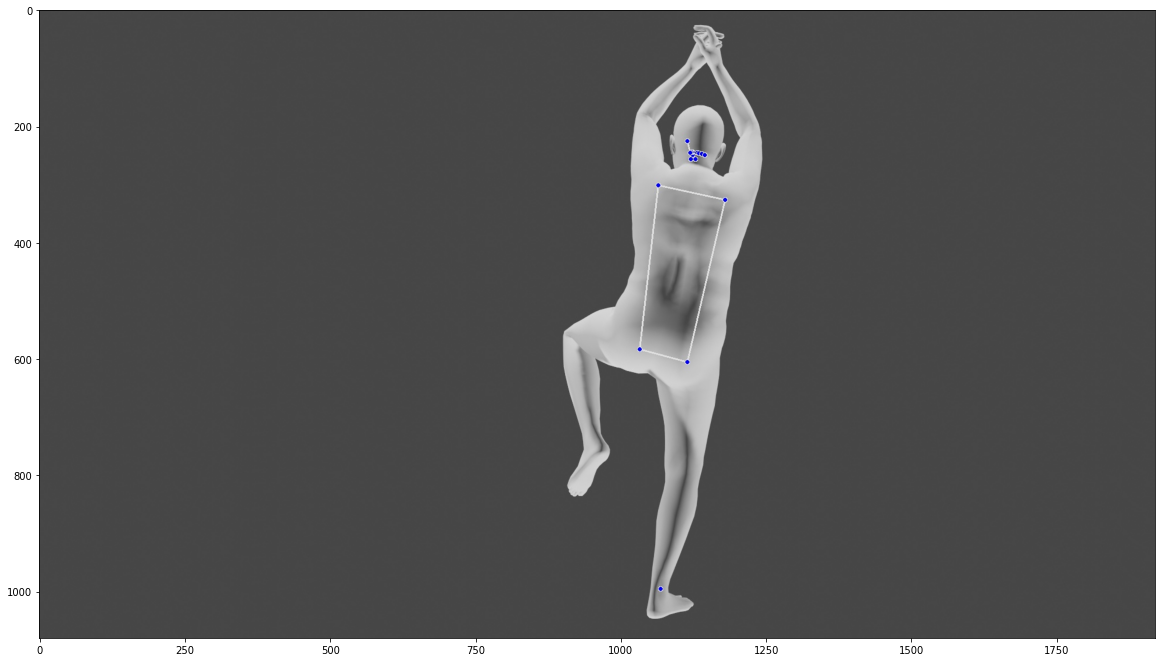

Outlier
  sample path =     D:\videos\yoga\yoga_images_out\yoga_raise\yoga772_cam028_50.jpg
  sample class =    yoga_raise
  detected class =  ['yoga_ready']
  all classes =     {'yoga_stretch_arm': 1, 'yoga_raise': 3, 'yoga_ready': 6}


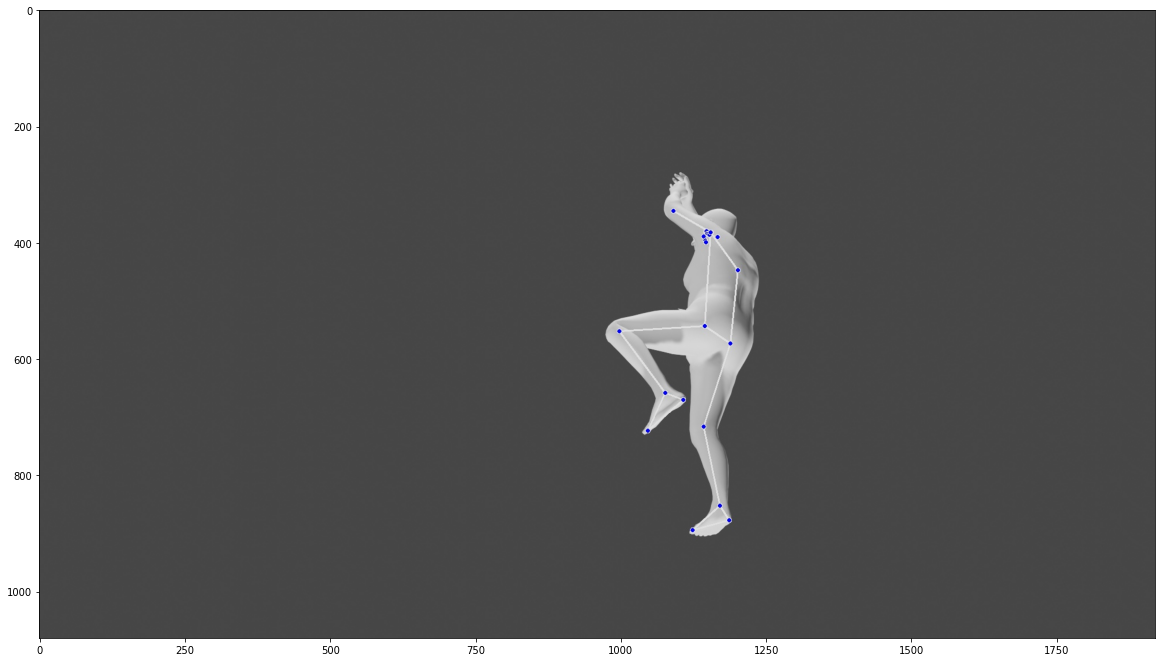

Outlier
  sample path =     D:\videos\yoga\yoga_images_out\yoga_raise\yoga772_cam029_50.jpg
  sample class =    yoga_raise
  detected class =  ['yoga_ready']
  all classes =     {'yoga_raise': 4, 'yoga_ready': 6}


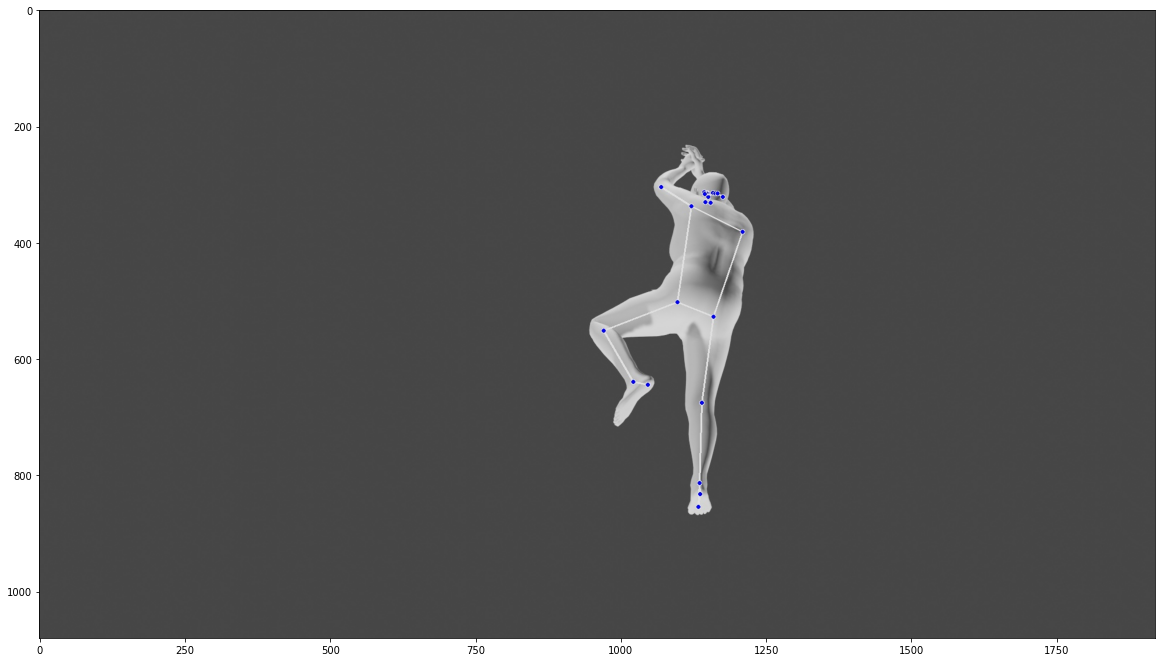

Outlier
  sample path =     D:\videos\yoga\yoga_images_out\yoga_raise\yoga772_cam034_50.jpg
  sample class =    yoga_raise
  detected class =  ['yoga_raise', 'yoga_ready']
  all classes =     {'yoga_stretch_arm': 2, 'yoga_raise': 4, 'yoga_ready': 4}


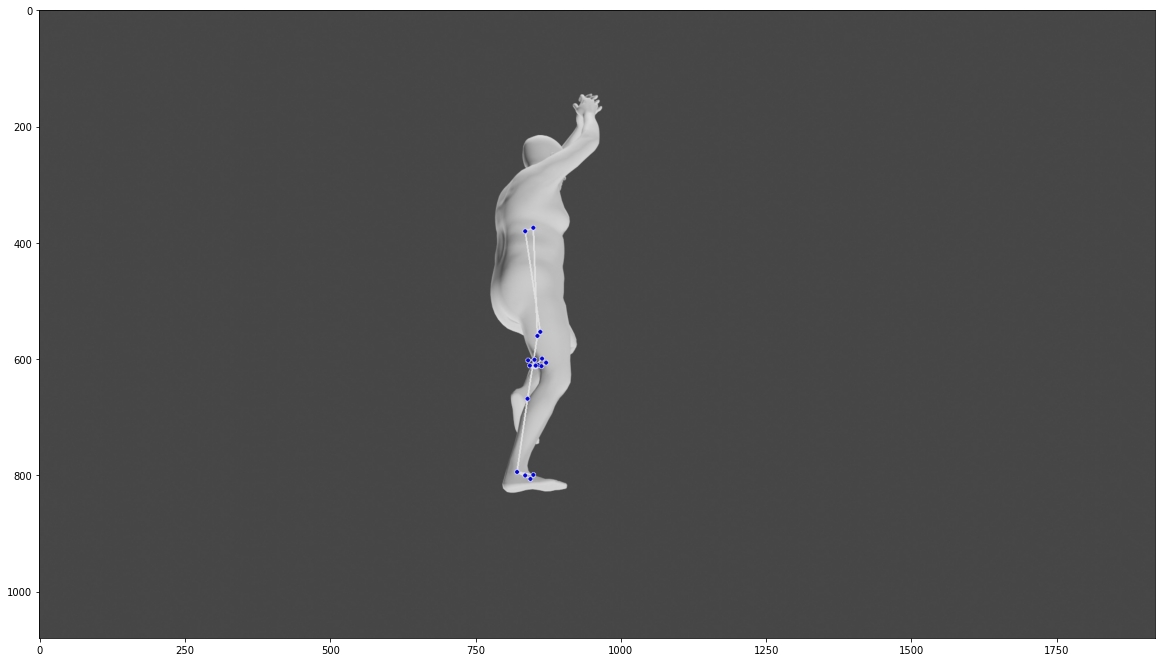

Outlier
  sample path =     D:\videos\yoga\yoga_images_out\yoga_stretch_arm\yoga772_cam034_140.jpg
  sample class =    yoga_stretch_arm
  detected class =  ['yoga_raise']
  all classes =     {'yoga_raise': 9, 'yoga_stretch_arm': 1}


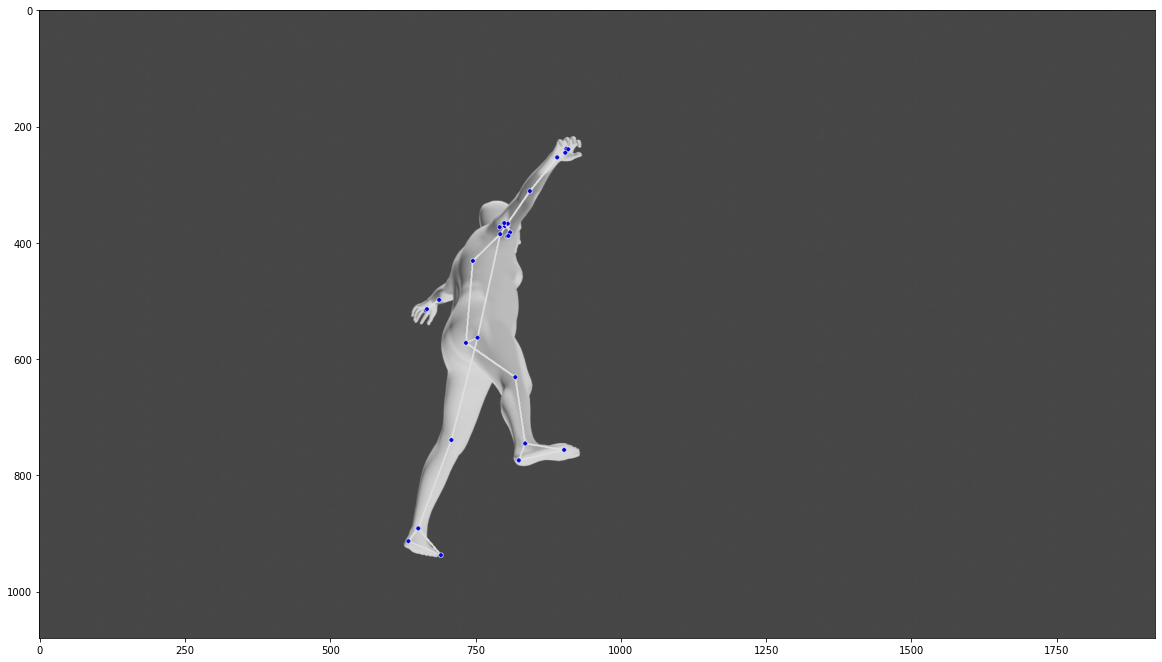

Outlier
  sample path =     D:\videos\yoga\yoga_images_out\yoga_stretch_arm\yoga_stretch_arm_jy20220301_125425.620.jpg
  sample class =    yoga_stretch_arm
  detected class =  ['yoga_stretch_arm', 'yoga_ready']
  all classes =     {'yoga_stretch_arm': 5, 'yoga_ready': 5}


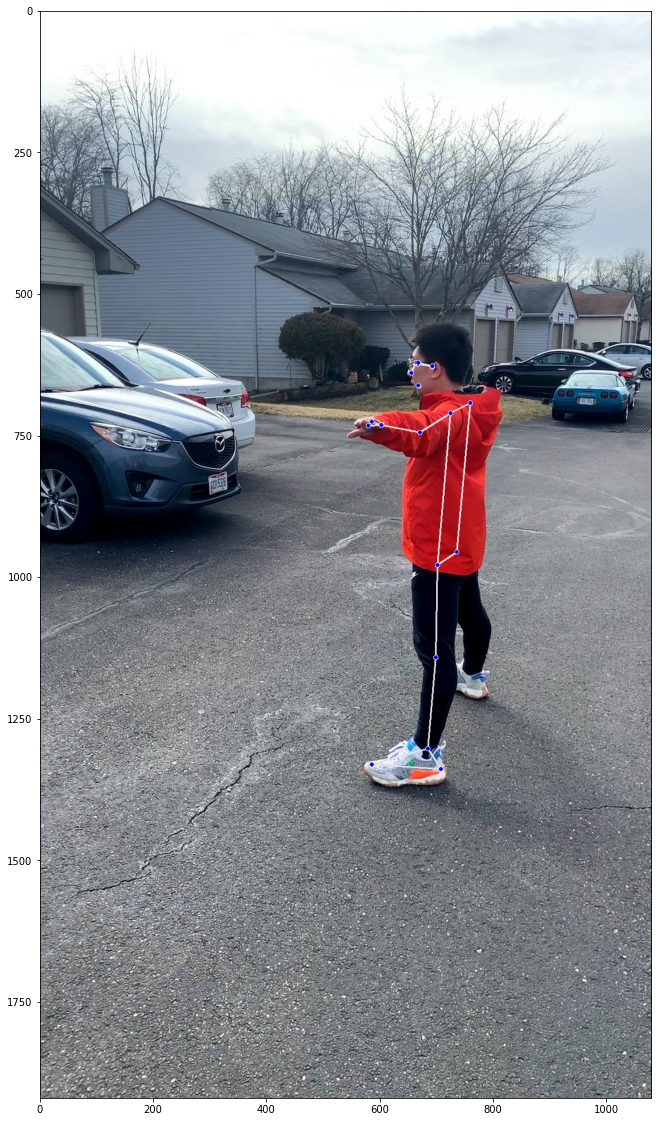

Outlier
  sample path =     D:\videos\yoga\yoga_images_out\yoga_stretch_arm\yoga_stretch_arm_wy20220301_125335.527.jpg
  sample class =    yoga_stretch_arm
  detected class =  ['yoga_ready']
  all classes =     {'yoga_raise': 1, 'yoga_stretch_arm': 1, 'yoga_ready': 8}


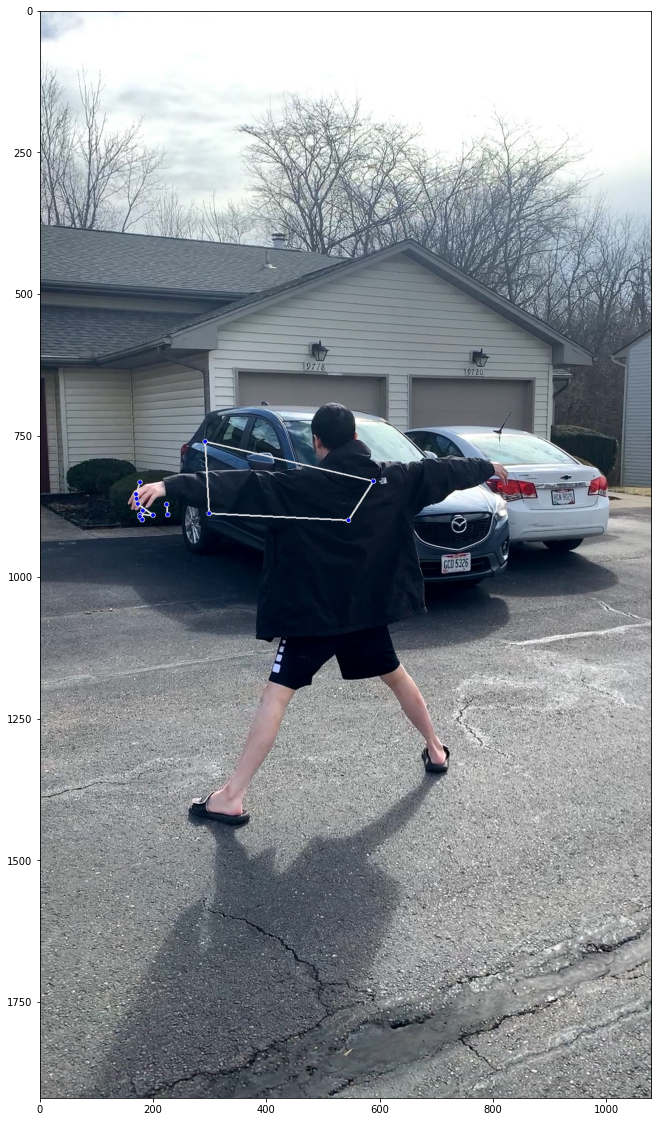

In [43]:
# Analyze outliers.
bootstrap_helper.analyze_outliers(outliers)

In [44]:
# Remove all outliers (if you don't want to manually pick).
bootstrap_helper.remove_outliers(outliers)

In [45]:
# Align CSVs with images after removing outliers.
bootstrap_helper.align_images_and_csvs(print_removed_items=False)
bootstrap_helper.print_images_out_statistics()

Number of images per pose class:
  yoga_raise: 130
  yoga_ready: 111
  yoga_stretch_arm: 130


## Dump for the App

Dump filtered poses to CSV and download it.

Please check this [guide](https://developers.google.com/ml-kit/vision/pose-detection/classifying-poses#4_integrate_with_the_ml_kit_quickstart_app) on how to use this CSV in the ML Kit sample app.

In [23]:
import csv
import os
import numpy as np


def dump_for_the_app():
  pose_samples_folder = r'D:\videos\yoga\yoga_csvs_out'
  pose_samples_csv_path = r'D:\videos\yoga\yoga_csvs_out.csv'
  file_extension = 'csv'
  file_separator = ','

  # Each file in the folder represents one pose class.
  file_names = [name for name in os.listdir(pose_samples_folder) if name.endswith(file_extension)]

  with open(pose_samples_csv_path, 'w') as csv_out:
    csv_out_writer = csv.writer(csv_out, delimiter=file_separator, quoting=csv.QUOTE_MINIMAL)
    for file_name in file_names:
      # Use file name as pose class name.
      class_name = file_name[:-(len(file_extension) + 1)]

      # One file line: `sample_00001,x1,y1,x2,y2,....`.
      with open(os.path.join(pose_samples_folder, file_name)) as csv_in:
        csv_in_reader = csv.reader(csv_in, delimiter=file_separator)
        for row in csv_in_reader:
          row.insert(1, class_name)
          csv_out_writer.writerow(row)

dump_for_the_app()

# Step 2: Classification

**Important!!** Check that you are using the same classification parameters as while building classifier.

In [77]:
# Specify your video name and target pose class to count the repetitions.
video_path = r'D:\videos\yoga\demo2.mp4'
class_names=['yoga_raise', 'yoga_stretch_arm', 'yoga_ready']
out_video_path = r'D:\videos\yoga\demo2_out4.mp4'

In [78]:
# Open the video.
import cv2

video_cap = cv2.VideoCapture(video_path)

# Get some video parameters to generate output video with classificaiton.
video_n_frames = video_cap.get(cv2.CAP_PROP_FRAME_COUNT)
video_fps = video_cap.get(cv2.CAP_PROP_FPS)
video_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
video_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

In [79]:
# Initilize tracker, classifier and counter.
# Do that before every video as all of them have state.
from mediapipe.python.solutions import pose as mp_pose

class_idx = 0
# Folder with pose class CSVs. That should be the same folder you using while
# building classifier to output CSVs.
pose_samples_folder = r'D:\videos\yoga\yoga_csvs_out'

# Initialize tracker.
pose_tracker = mp_pose.Pose(model_complexity=2,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

# Initialize embedder.
pose_embedder = FullBodyPoseEmbedder()

# Initialize classifier.
# Check that you are using the same parameters as during bootstrapping.
pose_classifier = PoseClassifier(
    pose_samples_folder=pose_samples_folder,
    pose_embedder=pose_embedder,
    top_n_by_max_distance=30,
    top_n_by_mean_distance=10)

# # Uncomment to validate target poses used by classifier and find outliers.
# outliers = pose_classifier.find_pose_sample_outliers()
# print('Number of pose sample outliers (consider removing them): ', len(outliers))

# Initialize EMA smoothing.
pose_classification_filter = EMADictSmoothing(
    window_size=10,
    alpha=0.2)

# Initialize checker.
pose_checker = PoseChecker(
    enter_threshold=6,
    exit_threshold=4
)

# Initialize renderer.
pose_classification_visualizer = PoseClassificationVisualizer(
    plot_x_max=video_n_frames,
    # Graphic looks nicer if it's the same as `top_n_by_mean_distance`.
    plot_y_max=10)

  0%|          | 0/316.0 [00:00<?, ?it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise


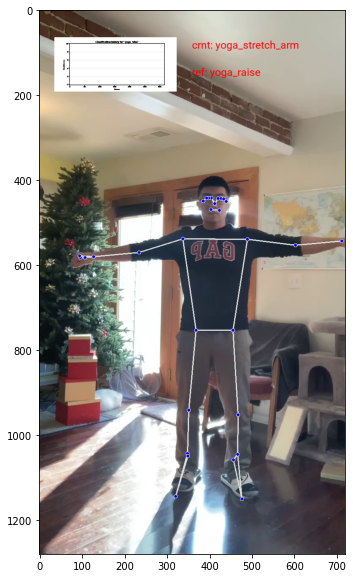

  0%|          | 1/316.0 [00:01<06:42,  1.28s/it]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  1%|          | 2/316.0 [00:01<03:15,  1.60it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


  1%|          | 3/316.0 [00:01<02:10,  2.39it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  1%|▏         | 4/316.0 [00:01<01:41,  3.07it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


  2%|▏         | 5/316.0 [00:01<01:24,  3.70it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  2%|▏         | 6/316.0 [00:02<01:21,  3.80it/s]

current ref pose is  yoga_raise
current ref pose is  yoga_raise


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  2%|▏         | 7/316.0 [00:02<01:14,  4.15it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  3%|▎         | 8/316.0 [00:02<01:06,  4.62it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


  3%|▎         | 9/316.0 [00:02<01:01,  5.03it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  3%|▎         | 10/316.0 [00:02<00:57,  5.29it/s]

current ref pose is  yoga_raise
current ref pose is  yoga_raise


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  3%|▎         | 11/316.0 [00:03<00:57,  5.27it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  4%|▍         | 12/316.0 [00:03<00:56,  5.36it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


  4%|▍         | 13/316.0 [00:03<00:54,  5.57it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  4%|▍         | 14/316.0 [00:03<00:52,  5.80it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


  5%|▍         | 15/316.0 [00:03<00:50,  5.97it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  5%|▌         | 16/316.0 [00:03<00:56,  5.33it/s]

current ref pose is  yoga_raise


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  5%|▌         | 17/316.0 [00:04<00:54,  5.47it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


  6%|▌         | 18/316.0 [00:04<00:53,  5.62it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  6%|▌         | 19/316.0 [00:04<00:56,  5.24it/s]

current ref pose is  yoga_raise
current ref pose is  yoga_raise


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  6%|▋         | 20/316.0 [00:04<00:55,  5.33it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  7%|▋         | 21/316.0 [00:04<00:52,  5.57it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


  7%|▋         | 22/316.0 [00:05<00:50,  5.80it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  7%|▋         | 23/316.0 [00:05<00:49,  5.91it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


  8%|▊         | 24/316.0 [00:05<00:50,  5.75it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  8%|▊         | 25/316.0 [00:05<00:49,  5.90it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  8%|▊         | 26/316.0 [00:05<00:48,  6.02it/s]

current ref pose is  yoga_raise
current ref pose is  yoga_raise


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  9%|▊         | 27/316.0 [00:05<00:47,  6.07it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


  9%|▉         | 28/316.0 [00:06<00:47,  6.05it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  9%|▉         | 29/316.0 [00:06<00:46,  6.17it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


  9%|▉         | 30/316.0 [00:06<00:47,  6.08it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 10%|▉         | 31/316.0 [00:06<00:46,  6.13it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 10%|█         | 32/316.0 [00:06<00:45,  6.18it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 10%|█         | 33/316.0 [00:06<00:46,  6.10it/s]

current ref pose is  yoga_raise
current ref pose is  yoga_raise


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 11%|█         | 34/316.0 [00:07<00:53,  5.23it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 11%|█         | 35/316.0 [00:07<01:00,  4.63it/s]

current ref pose is  yoga_raise
current ref pose is  yoga_raise


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 11%|█▏        | 36/316.0 [00:07<00:57,  4.86it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 12%|█▏        | 37/316.0 [00:07<00:53,  5.18it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 12%|█▏        | 38/316.0 [00:07<00:51,  5.42it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 12%|█▏        | 39/316.0 [00:08<00:49,  5.61it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 13%|█▎        | 40/316.0 [00:08<00:47,  5.77it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 13%|█▎        | 41/316.0 [00:08<00:46,  5.91it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 13%|█▎        | 42/316.0 [00:08<00:45,  5.99it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 14%|█▎        | 43/316.0 [00:08<00:45,  6.06it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 14%|█▍        | 44/316.0 [00:08<00:44,  6.16it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 14%|█▍        | 45/316.0 [00:09<00:44,  6.11it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 15%|█▍        | 46/316.0 [00:09<00:44,  6.10it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 15%|█▍        | 47/316.0 [00:09<00:44,  6.07it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 15%|█▌        | 48/316.0 [00:09<00:43,  6.12it/s]

current ref pose is  yoga_raise
current ref pose is  yoga_raise


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 16%|█▌        | 49/316.0 [00:09<00:45,  5.82it/s]

current ref pose is  yoga_raise
current ref pose is  yoga_raise


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 16%|█▌        | 50/316.0 [00:09<00:48,  5.54it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise


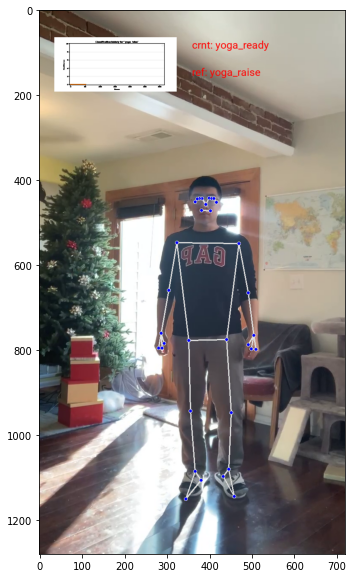

 16%|█▌        | 51/316.0 [00:10<01:06,  4.01it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 16%|█▋        | 52/316.0 [00:10<00:58,  4.48it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 17%|█▋        | 53/316.0 [00:10<00:53,  4.87it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 17%|█▋        | 54/316.0 [00:10<00:50,  5.15it/s]

current ref pose is  yoga_raise
current ref pose is  yoga_raise


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 17%|█▋        | 55/316.0 [00:11<00:58,  4.46it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 18%|█▊        | 56/316.0 [00:11<00:53,  4.84it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 18%|█▊        | 57/316.0 [00:11<00:50,  5.17it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 18%|█▊        | 58/316.0 [00:11<00:47,  5.43it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 19%|█▊        | 59/316.0 [00:11<00:45,  5.59it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 19%|█▉        | 60/316.0 [00:11<00:44,  5.77it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 19%|█▉        | 61/316.0 [00:12<00:43,  5.87it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 20%|█▉        | 62/316.0 [00:12<00:42,  5.92it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 20%|█▉        | 63/316.0 [00:12<00:42,  5.89it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 20%|██        | 64/316.0 [00:12<00:44,  5.72it/s]

current ref pose is  yoga_raise


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 21%|██        | 65/316.0 [00:12<00:46,  5.35it/s]

current ref pose is  yoga_raise
current ref pose is  yoga_raise


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 21%|██        | 66/316.0 [00:13<00:47,  5.26it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 21%|██        | 67/316.0 [00:13<00:46,  5.32it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 22%|██▏       | 68/316.0 [00:13<00:44,  5.57it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 22%|██▏       | 69/316.0 [00:13<00:42,  5.78it/s]

current ref pose is  yoga_raise
current ref pose is  yoga_raise


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 22%|██▏       | 70/316.0 [00:13<00:46,  5.26it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 22%|██▏       | 71/316.0 [00:13<00:45,  5.44it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 23%|██▎       | 72/316.0 [00:14<00:42,  5.69it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 23%|██▎       | 73/316.0 [00:14<00:41,  5.82it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 23%|██▎       | 74/316.0 [00:14<00:41,  5.87it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 24%|██▎       | 75/316.0 [00:14<00:40,  5.99it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 24%|██▍       | 76/316.0 [00:14<00:39,  6.09it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 24%|██▍       | 77/316.0 [00:14<00:38,  6.16it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 25%|██▍       | 78/316.0 [00:15<00:39,  6.01it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 25%|██▌       | 79/316.0 [00:15<00:46,  5.14it/s]

current ref pose is  yoga_raise
current ref pose is  yoga_raise


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 25%|██▌       | 80/316.0 [00:15<00:44,  5.31it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 26%|██▌       | 81/316.0 [00:15<00:42,  5.57it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 26%|██▌       | 82/316.0 [00:15<00:40,  5.79it/s]

current ref pose is  yoga_raise
current ref pose is  yoga_raise


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 26%|██▋       | 83/316.0 [00:15<00:39,  5.89it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 27%|██▋       | 84/316.0 [00:16<00:39,  5.90it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 27%|██▋       | 85/316.0 [00:16<00:38,  6.00it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 27%|██▋       | 86/316.0 [00:16<00:37,  6.06it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 28%|██▊       | 87/316.0 [00:16<00:37,  6.07it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise
start_timer


 28%|██▊       | 88/316.0 [00:16<00:37,  6.11it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 28%|██▊       | 89/316.0 [00:17<00:43,  5.28it/s]

current ref pose is  yoga_raise


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 28%|██▊       | 90/316.0 [00:17<00:42,  5.38it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 29%|██▉       | 91/316.0 [00:17<00:40,  5.53it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 29%|██▉       | 92/316.0 [00:17<00:39,  5.62it/s]

current ref pose is  yoga_raise


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 29%|██▉       | 93/316.0 [00:17<00:43,  5.17it/s]

current ref pose is  yoga_raise
current ref pose is  yoga_raise


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 30%|██▉       | 94/316.0 [00:17<00:42,  5.21it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 30%|███       | 95/316.0 [00:18<00:40,  5.47it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 30%|███       | 96/316.0 [00:18<00:39,  5.56it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 31%|███       | 97/316.0 [00:18<00:38,  5.66it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 31%|███       | 98/316.0 [00:18<00:37,  5.87it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 31%|███▏      | 99/316.0 [00:18<00:36,  5.99it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 32%|███▏      | 100/316.0 [00:18<00:35,  6.03it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise


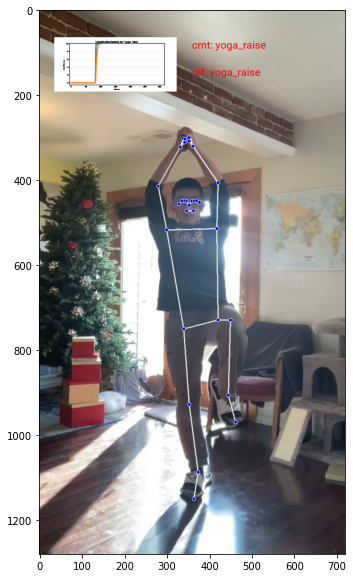

 32%|███▏      | 101/316.0 [00:19<00:51,  4.20it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 32%|███▏      | 102/316.0 [00:19<00:50,  4.21it/s]

current ref pose is  yoga_raise
current ref pose is  yoga_raise


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 33%|███▎      | 103/316.0 [00:19<00:47,  4.48it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 33%|███▎      | 104/316.0 [00:19<00:43,  4.84it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 33%|███▎      | 105/316.0 [00:20<00:40,  5.19it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 34%|███▎      | 106/316.0 [00:20<00:38,  5.48it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 34%|███▍      | 107/316.0 [00:20<00:37,  5.60it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 34%|███▍      | 108/316.0 [00:20<00:35,  5.78it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 34%|███▍      | 109/316.0 [00:20<00:34,  5.95it/s]

current ref pose is  yoga_raise
current ref pose is  yoga_raise


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 35%|███▍      | 110/316.0 [00:20<00:34,  5.93it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 35%|███▌      | 111/316.0 [00:21<00:33,  6.07it/s]

current ref pose is  yoga_raise
current ref pose is  yoga_raise


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 35%|███▌      | 112/316.0 [00:21<00:41,  4.90it/s]

current ref pose is  yoga_raise


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 36%|███▌      | 113/316.0 [00:21<00:39,  5.16it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 36%|███▌      | 114/316.0 [00:21<00:37,  5.42it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 36%|███▋      | 115/316.0 [00:21<00:35,  5.60it/s]

current ref pose is  yoga_raise
current ref pose is  yoga_raise


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 37%|███▋      | 116/316.0 [00:22<00:35,  5.66it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 37%|███▋      | 117/316.0 [00:22<00:34,  5.82it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 37%|███▋      | 118/316.0 [00:22<00:33,  5.91it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 38%|███▊      | 119/316.0 [00:22<00:33,  5.93it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 38%|███▊      | 120/316.0 [00:22<00:32,  6.04it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 38%|███▊      | 121/316.0 [00:22<00:32,  6.04it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 39%|███▊      | 122/316.0 [00:23<00:32,  6.00it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 39%|███▉      | 123/316.0 [00:23<00:34,  5.60it/s]

current ref pose is  yoga_raise


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 39%|███▉      | 124/316.0 [00:23<00:36,  5.22it/s]

current ref pose is  yoga_raise
current ref pose is  yoga_raise


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 40%|███▉      | 125/316.0 [00:23<00:36,  5.21it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 40%|███▉      | 126/316.0 [00:23<00:35,  5.34it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 40%|████      | 127/316.0 [00:23<00:33,  5.57it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 41%|████      | 128/316.0 [00:24<00:32,  5.76it/s]

current ref pose is  yoga_raise
current ref pose is  yoga_raise


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 41%|████      | 129/316.0 [00:24<00:36,  5.17it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 41%|████      | 130/316.0 [00:24<00:34,  5.43it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_raise
current ref pose is  yoga_raise


 41%|████▏     | 131/316.0 [00:24<00:33,  5.60it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 42%|████▏     | 132/316.0 [00:24<00:32,  5.69it/s]

current ref pose is  yoga_raise
current ref pose is  yoga_raise


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 42%|████▏     | 133/316.0 [00:25<00:33,  5.40it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 42%|████▏     | 134/316.0 [00:25<00:34,  5.30it/s]

current ref pose is  yoga_raise
current ref pose is  yoga_raise


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 43%|████▎     | 135/316.0 [00:25<00:34,  5.23it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 43%|████▎     | 136/316.0 [00:25<00:34,  5.20it/s]

current ref pose is  yoga_raise
current ref pose is  yoga_raise
duration 9.086058378219604


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 43%|████▎     | 137/316.0 [00:25<00:35,  5.11it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 44%|████▎     | 138/316.0 [00:26<00:38,  4.66it/s]

current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 44%|████▍     | 139/316.0 [00:26<00:38,  4.57it/s]

current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 44%|████▍     | 140/316.0 [00:26<00:39,  4.47it/s]

current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 45%|████▍     | 141/316.0 [00:26<00:37,  4.67it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 45%|████▍     | 142/316.0 [00:26<00:35,  4.89it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 45%|████▌     | 143/316.0 [00:27<00:33,  5.21it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 46%|████▌     | 144/316.0 [00:27<00:32,  5.24it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 46%|████▌     | 145/316.0 [00:27<00:31,  5.47it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 46%|████▌     | 146/316.0 [00:27<00:30,  5.60it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 47%|████▋     | 147/316.0 [00:27<00:29,  5.74it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 47%|████▋     | 148/316.0 [00:28<00:29,  5.65it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 47%|████▋     | 149/316.0 [00:28<00:28,  5.76it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm


 47%|████▋     | 150/316.0 [00:28<00:34,  4.85it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm


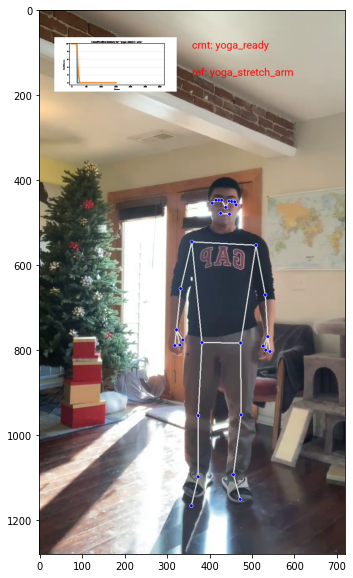

 48%|████▊     | 151/316.0 [00:28<00:46,  3.57it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 48%|████▊     | 152/316.0 [00:29<00:40,  4.00it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 48%|████▊     | 153/316.0 [00:29<00:36,  4.47it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 49%|████▊     | 154/316.0 [00:29<00:33,  4.88it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 49%|████▉     | 155/316.0 [00:29<00:30,  5.22it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 49%|████▉     | 156/316.0 [00:29<00:29,  5.48it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 50%|████▉     | 157/316.0 [00:29<00:28,  5.64it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 50%|█████     | 158/316.0 [00:30<00:27,  5.82it/s]

current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 50%|█████     | 159/316.0 [00:30<00:27,  5.70it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 51%|█████     | 160/316.0 [00:30<00:26,  5.79it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 51%|█████     | 161/316.0 [00:30<00:26,  5.93it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 51%|█████▏    | 162/316.0 [00:30<00:25,  6.00it/s]

current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 52%|█████▏    | 163/316.0 [00:30<00:28,  5.35it/s]

current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 52%|█████▏    | 164/316.0 [00:31<00:28,  5.41it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 52%|█████▏    | 165/316.0 [00:31<00:32,  4.71it/s]

current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 53%|█████▎    | 166/316.0 [00:31<00:30,  4.91it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 53%|█████▎    | 167/316.0 [00:31<00:29,  5.13it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 53%|█████▎    | 168/316.0 [00:31<00:27,  5.36it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 53%|█████▎    | 169/316.0 [00:32<00:26,  5.55it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 54%|█████▍    | 170/316.0 [00:32<00:25,  5.69it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 54%|█████▍    | 171/316.0 [00:32<00:25,  5.71it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 54%|█████▍    | 172/316.0 [00:32<00:24,  5.81it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 55%|█████▍    | 173/316.0 [00:32<00:24,  5.84it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 55%|█████▌    | 174/316.0 [00:32<00:24,  5.83it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 55%|█████▌    | 175/316.0 [00:33<00:30,  4.60it/s]

current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 56%|█████▌    | 176/316.0 [00:33<00:29,  4.81it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 56%|█████▌    | 177/316.0 [00:33<00:26,  5.18it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 56%|█████▋    | 178/316.0 [00:33<00:25,  5.47it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 57%|█████▋    | 179/316.0 [00:33<00:24,  5.65it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 57%|█████▋    | 180/316.0 [00:34<00:23,  5.80it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 57%|█████▋    | 181/316.0 [00:34<00:22,  5.90it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 58%|█████▊    | 182/316.0 [00:34<00:22,  6.02it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 58%|█████▊    | 183/316.0 [00:34<00:22,  5.97it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 58%|█████▊    | 184/316.0 [00:34<00:21,  6.04it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 59%|█████▊    | 185/316.0 [00:34<00:21,  6.11it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 59%|█████▉    | 186/316.0 [00:35<00:21,  6.03it/s]

current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 59%|█████▉    | 187/316.0 [00:35<00:23,  5.48it/s]

current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 59%|█████▉    | 188/316.0 [00:35<00:23,  5.43it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 60%|█████▉    | 189/316.0 [00:35<00:23,  5.48it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 60%|██████    | 190/316.0 [00:35<00:22,  5.65it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 60%|██████    | 191/316.0 [00:36<00:21,  5.72it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 61%|██████    | 192/316.0 [00:36<00:21,  5.89it/s]

current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 61%|██████    | 193/316.0 [00:36<00:20,  5.97it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 61%|██████▏   | 194/316.0 [00:36<00:20,  6.03it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 62%|██████▏   | 195/316.0 [00:36<00:23,  5.13it/s]

current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 62%|██████▏   | 196/316.0 [00:36<00:22,  5.32it/s]

current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 62%|██████▏   | 197/316.0 [00:37<00:24,  4.95it/s]

current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 63%|██████▎   | 198/316.0 [00:37<00:23,  5.00it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 63%|██████▎   | 199/316.0 [00:37<00:22,  5.23it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 63%|██████▎   | 200/316.0 [00:37<00:21,  5.49it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm


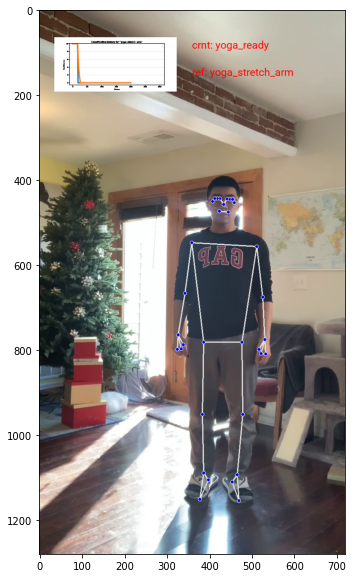

 64%|██████▎   | 201/316.0 [00:38<00:29,  3.93it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 64%|██████▍   | 202/316.0 [00:38<00:27,  4.11it/s]

current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 64%|██████▍   | 203/316.0 [00:38<00:25,  4.44it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 65%|██████▍   | 204/316.0 [00:38<00:23,  4.74it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 65%|██████▍   | 205/316.0 [00:38<00:22,  5.03it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 65%|██████▌   | 206/316.0 [00:39<00:20,  5.29it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 66%|██████▌   | 207/316.0 [00:39<00:19,  5.53it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 66%|██████▌   | 208/316.0 [00:39<00:19,  5.62it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 66%|██████▌   | 209/316.0 [00:39<00:18,  5.80it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 66%|██████▋   | 210/316.0 [00:39<00:17,  5.95it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 67%|██████▋   | 211/316.0 [00:39<00:17,  6.02it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 67%|██████▋   | 212/316.0 [00:40<00:17,  5.80it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 67%|██████▋   | 213/316.0 [00:40<00:17,  5.95it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 68%|██████▊   | 214/316.0 [00:40<00:16,  6.01it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 68%|██████▊   | 215/316.0 [00:40<00:16,  6.07it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 68%|██████▊   | 216/316.0 [00:40<00:16,  6.12it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 69%|██████▊   | 217/316.0 [00:40<00:16,  6.16it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 69%|██████▉   | 218/316.0 [00:41<00:16,  6.06it/s]

current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 69%|██████▉   | 219/316.0 [00:41<00:20,  4.78it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 70%|██████▉   | 220/316.0 [00:41<00:18,  5.12it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 70%|██████▉   | 221/316.0 [00:41<00:17,  5.41it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 70%|███████   | 222/316.0 [00:41<00:16,  5.60it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 71%|███████   | 223/316.0 [00:41<00:16,  5.67it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 71%|███████   | 224/316.0 [00:42<00:16,  5.61it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 71%|███████   | 225/316.0 [00:42<00:16,  5.62it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 72%|███████▏  | 226/316.0 [00:42<00:15,  5.79it/s]

current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 72%|███████▏  | 227/316.0 [00:42<00:15,  5.83it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 72%|███████▏  | 228/316.0 [00:42<00:14,  5.87it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
start_timer
current ref pose is  yoga_stretch_arm


 72%|███████▏  | 229/316.0 [00:42<00:14,  5.93it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 73%|███████▎  | 230/316.0 [00:43<00:14,  5.92it/s]

current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 73%|███████▎  | 231/316.0 [00:43<00:15,  5.59it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 73%|███████▎  | 232/316.0 [00:43<00:16,  4.96it/s]

current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 74%|███████▎  | 233/316.0 [00:43<00:16,  5.16it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 74%|███████▍  | 234/316.0 [00:43<00:15,  5.30it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 74%|███████▍  | 235/316.0 [00:44<00:14,  5.55it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 75%|███████▍  | 236/316.0 [00:44<00:14,  5.63it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 75%|███████▌  | 237/316.0 [00:44<00:13,  5.80it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 75%|███████▌  | 238/316.0 [00:44<00:15,  5.14it/s]

current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 76%|███████▌  | 239/316.0 [00:44<00:14,  5.34it/s]

current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 76%|███████▌  | 240/316.0 [00:45<00:15,  4.92it/s]

current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 76%|███████▋  | 241/316.0 [00:45<00:15,  4.97it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 77%|███████▋  | 242/316.0 [00:45<00:14,  5.21it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 77%|███████▋  | 243/316.0 [00:45<00:13,  5.48it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 77%|███████▋  | 244/316.0 [00:45<00:12,  5.69it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 78%|███████▊  | 245/316.0 [00:45<00:12,  5.79it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 78%|███████▊  | 246/316.0 [00:46<00:11,  5.91it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 78%|███████▊  | 247/316.0 [00:46<00:11,  5.93it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 78%|███████▊  | 248/316.0 [00:46<00:11,  5.88it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 79%|███████▉  | 249/316.0 [00:46<00:11,  5.95it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 79%|███████▉  | 250/316.0 [00:46<00:11,  5.97it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


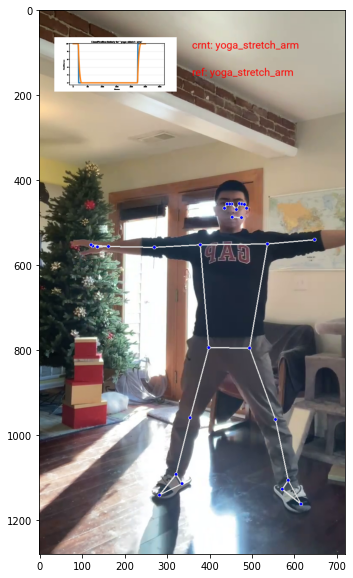

 79%|███████▉  | 251/316.0 [00:47<00:15,  4.18it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 80%|███████▉  | 252/316.0 [00:47<00:14,  4.53it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 80%|████████  | 253/316.0 [00:47<00:13,  4.83it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 80%|████████  | 254/316.0 [00:47<00:12,  5.16it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 81%|████████  | 255/316.0 [00:47<00:11,  5.36it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 81%|████████  | 256/316.0 [00:48<00:11,  5.40it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 81%|████████▏ | 257/316.0 [00:48<00:10,  5.57it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 82%|████████▏ | 258/316.0 [00:48<00:10,  5.65it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 82%|████████▏ | 259/316.0 [00:48<00:09,  5.79it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 82%|████████▏ | 260/316.0 [00:48<00:11,  4.69it/s]

current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 83%|████████▎ | 261/316.0 [00:49<00:10,  5.01it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 83%|████████▎ | 262/316.0 [00:49<00:10,  5.31it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 83%|████████▎ | 263/316.0 [00:49<00:09,  5.41it/s]

current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 84%|████████▎ | 264/316.0 [00:49<00:10,  5.01it/s]

current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 84%|████████▍ | 265/316.0 [00:49<00:10,  4.98it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 84%|████████▍ | 266/316.0 [00:50<00:09,  5.15it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 84%|████████▍ | 267/316.0 [00:50<00:08,  5.45it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 85%|████████▍ | 268/316.0 [00:50<00:08,  5.52it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 85%|████████▌ | 269/316.0 [00:50<00:08,  5.60it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 85%|████████▌ | 270/316.0 [00:50<00:08,  5.21it/s]

current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 86%|████████▌ | 271/316.0 [00:50<00:08,  5.22it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 86%|████████▌ | 272/316.0 [00:51<00:08,  5.39it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 86%|████████▋ | 273/316.0 [00:51<00:07,  5.55it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 87%|████████▋ | 274/316.0 [00:51<00:07,  5.59it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 87%|████████▋ | 275/316.0 [00:51<00:07,  5.75it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 87%|████████▋ | 276/316.0 [00:51<00:06,  5.81it/s]

current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 88%|████████▊ | 277/316.0 [00:52<00:07,  5.01it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 88%|████████▊ | 278/316.0 [00:52<00:07,  5.19it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 88%|████████▊ | 279/316.0 [00:52<00:06,  5.42it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 89%|████████▊ | 280/316.0 [00:52<00:06,  5.63it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 89%|████████▉ | 281/316.0 [00:52<00:06,  5.76it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 89%|████████▉ | 282/316.0 [00:52<00:05,  5.83it/s]

current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 90%|████████▉ | 283/316.0 [00:53<00:06,  5.13it/s]

current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 90%|████████▉ | 284/316.0 [00:53<00:06,  5.18it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 90%|█████████ | 285/316.0 [00:53<00:05,  5.28it/s]

current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 91%|█████████ | 286/316.0 [00:53<00:05,  5.38it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 91%|█████████ | 287/316.0 [00:53<00:05,  5.55it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


 91%|█████████ | 288/316.0 [00:54<00:05,  5.58it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 91%|█████████▏| 289/316.0 [00:54<00:05,  5.09it/s]

current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 92%|█████████▏| 290/316.0 [00:54<00:05,  5.01it/s]

current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 92%|█████████▏| 291/316.0 [00:54<00:04,  5.11it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 92%|█████████▏| 292/316.0 [00:54<00:04,  5.32it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_stretch_arm
current ref pose is  yoga_stretch_arm
duration 12.15322494506836


 93%|█████████▎| 293/316.0 [00:54<00:04,  5.52it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 93%|█████████▎| 294/316.0 [00:55<00:03,  5.59it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_ready
start_timer
current ref pose is  yoga_ready


 93%|█████████▎| 295/316.0 [00:55<00:03,  5.70it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 94%|█████████▎| 296/316.0 [00:55<00:03,  5.73it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_ready
current ref pose is  yoga_ready


 94%|█████████▍| 297/316.0 [00:55<00:03,  5.85it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 94%|█████████▍| 298/316.0 [00:55<00:03,  5.11it/s]

current ref pose is  yoga_ready


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 95%|█████████▍| 299/316.0 [00:56<00:03,  5.26it/s]

current ref pose is  yoga_ready
current ref pose is  yoga_ready


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 95%|█████████▍| 300/316.0 [00:56<00:02,  5.34it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_ready


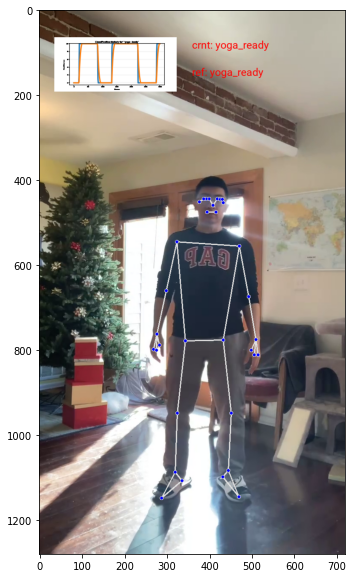

 95%|█████████▌| 301/316.0 [00:56<00:04,  3.60it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 96%|█████████▌| 302/316.0 [00:56<00:03,  3.99it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_ready
current ref pose is  yoga_ready


 96%|█████████▌| 303/316.0 [00:57<00:02,  4.39it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 96%|█████████▌| 304/316.0 [00:57<00:02,  4.70it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_ready
current ref pose is  yoga_ready


 97%|█████████▋| 305/316.0 [00:57<00:02,  5.03it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 97%|█████████▋| 306/316.0 [00:57<00:01,  5.17it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_ready
current ref pose is  yoga_ready


 97%|█████████▋| 307/316.0 [00:57<00:01,  5.43it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 97%|█████████▋| 308/316.0 [00:57<00:01,  5.57it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_ready
current ref pose is  yoga_ready


 98%|█████████▊| 309/316.0 [00:58<00:01,  5.71it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 98%|█████████▊| 310/316.0 [00:58<00:01,  4.89it/s]

current ref pose is  yoga_ready
current ref pose is  yoga_ready


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 98%|█████████▊| 311/316.0 [00:58<00:00,  5.06it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 99%|█████████▊| 312/316.0 [00:58<00:00,  5.29it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_ready
current ref pose is  yoga_ready


 99%|█████████▉| 313/316.0 [00:58<00:00,  5.47it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 99%|█████████▉| 314/316.0 [00:59<00:00,  5.67it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


current ref pose is  yoga_ready
current ref pose is  yoga_ready


100%|█████████▉| 315/316.0 [00:59<00:00,  5.82it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 316/316.0 [00:59<00:00,  5.32it/s]

current ref pose is  yoga_ready


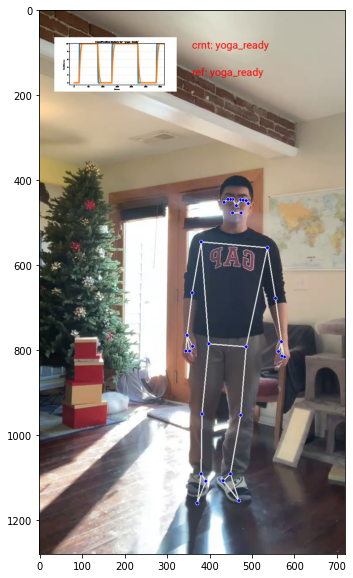

In [80]:
# Run classification on a video.
import os
import tqdm
import time

from mediapipe.python.solutions import drawing_utils as mp_drawing


# Open output video.
out_video = cv2.VideoWriter(out_video_path, cv2.VideoWriter_fourcc(
    *'mp4v'), video_fps, (video_width, video_height))


frame_idx = 0
start_timer = 0
start_flag = False
exit_flag = True
duration = 0
completed = False
output_frame = None

while True:
    # Get next frame of the video.
    success, input_frame = video_cap.read()
    if not success:
        break

    # Run pose tracker.
    input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
    result = pose_tracker.process(image=input_frame)
    pose_landmarks = result.pose_landmarks

    # Draw pose prediction.
    output_frame = input_frame.copy()
    if pose_landmarks is not None:
        mp_drawing.draw_landmarks(
            image=output_frame,
            landmark_list=pose_landmarks,
            connections=mp_pose.POSE_CONNECTIONS)

    if pose_landmarks is not None:
        # Get landmarks.
        frame_height, frame_width = output_frame.shape[0], output_frame.shape[1]
        pose_landmarks = np.array([[lmk.x * frame_width, lmk.y * frame_height, lmk.z * frame_width]
                                   for lmk in pose_landmarks.landmark], dtype=np.float32)
        assert pose_landmarks.shape == (33, 3), 'Unexpected landmarks shape: {}'.format(pose_landmarks.shape)

        # Classify the pose on the current frame.
        pose_classification = pose_classifier(pose_landmarks)

        # Smooth classification using EMA.
        pose_classification_filtered = pose_classification_filter(pose_classification)

        enter, exit = pose_checker(class_names[class_idx], pose_classification_filtered)
        # if enter and not start_flag:
        #     start_timer = time.time()
        #     start_flag = True
        #     exit_flag = False
        #     print('start_timer')

        # if exit and not exit_flag:
        #     exit_flag = True
        #     start_flag = False
        #     duration = time.time() - start_timer
        #     print('duration', duration)
        #     if duration > 3:
        #         class_idx += 1
        #         if class_idx > 2:
        #             completed = True
        #             class_idx = 2
        #     duration = 0
    else:
        # No pose => no classification on current frame.
        pose_classification = None

        # Still add empty classification to the filter to maintaing correct
        # smoothing for future frames.
        pose_classification_filtered = pose_classification_filter(dict())
        pose_classification_filtered = None

        # Don't update the counter presuming that person is 'frozen'. Just
        # take the latest repetitions count.
        # repetitions_count = repetition_counter.n_repeats

    # Draw classification plot and repetition counter.
    if not completed:
        output_frame = pose_classification_visualizer(
            class_name=class_names[class_idx],
            frame=output_frame,
            pose_classification=pose_classification,
            pose_classification_filtered=pose_classification_filtered,
        )
    if completed:
        output_frame = pose_classification_visualizer(
            class_name="done",
            frame=output_frame,
            pose_classification=pose_classification,
            pose_classification_filtered=pose_classification_filtered,
        )

    # Save the output frame.
    # out_video.write(cv2.cvtColor(np.array(output_frame), cv2.COLOR_RGB2BGR))

    # Show intermediate frames of the video to track progress.
    # if frame_idx % 50 == 0:
    #     show_image(output_frame)

    frame_idx += 1

# Close output video.
out_video.release()

# Release MediaPipe resources.
pose_tracker.close()

# Show the last frame of the video.
# if output_frame is not None:
#     show_image(output_frame)